# Prévisions météorologiques en Australie

# Prévision des précipitations sans étape de ré-échantillonage

## Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [3]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, make_scorer, get_scorer_names, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

In [4]:
# définition d'une option de visualisation des DataFrames 
pd.set_option("display.max_colwidth", 200)

## Préparation du jeu de données et paramètrage

In [5]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [6]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [7]:
# division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)

In [8]:
# distribution de la variable cible dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible dans l'ensemble d'entraînement:", 
      dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble d'entraînement: {0: 76696, 1: 21854}


In [9]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.778245
1    0.221755
Name: RainTomorrow, dtype: float64

In [10]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 32890, 1: 9347}


In [11]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.778701
1    0.221299
Name: RainTomorrow, dtype: float64

In [12]:
# paramètre à initialiser pour calculer les performances des algorithmes sans ré-échantillonage
param_ru = 'none'

In [13]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modèles de classification binaire par apprentissage supervisé

### Définition des fonctions et variables globales

In [14]:
# définition des métriques d'évaluation adaptées aux modèles de classification déséquilibrés 
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [15]:
# affichage des performances moyennes obtenues par validation croisée pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [16]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
def create_probas_dataframe(X_test_scaled, y_probas_test, y_test):
    df_probas_test = pd.DataFrame({'y_train_pred':y_probas_test[:,1], 'y_test':y_test})
    df_probas_test['Prévisions'] = df_probas_test.y_train_pred.map(lambda x: 1 if x > 0.5 else 0)
    for i in [float(x)/200 for x in range(200)]:
        df_probas_test[i] = df_probas_test.y_train_pred.map(lambda x: 1 if x > i else 0)
    return df_probas_test

In [17]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
def compute_metrics_with_probas(df_probas_test, y_test):
    df_metrics_probas = pd.DataFrame(columns = ['Probabilités','accuracy','sensitivité','spécificité','f1_score','f1_macro','bal_acc','moy_geom','roc_auc'])
    for i in [float(x)/200 for x in range(200)]:
        cm = metrics.confusion_matrix(y_test, df_probas_test[i])
        Accuracy = (cm[0,0]+cm[1,1])/np.sum(cm)
        Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
        Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
        F1_score = f1_score(y_test, df_probas_test[i])
        F1_macro = f1_score(y_test, df_probas_test[i], average='macro')
        Bal_Acc = balanced_accuracy_score(y_test, df_probas_test[i])
        Geom_Mean = geometric_mean_score(y_test, df_probas_test[i])
        ROC_AUC = roc_auc_score(y_test, df_probas_test[i])
        df_metrics_probas.loc[i] = [i, Accuracy, Sensitivity, Specificity, F1_score, F1_macro, Bal_Acc, Geom_Mean, ROC_AUC]
    return df_metrics_probas

In [18]:
def plot_metrics_with_probas(df_metrics_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1 = df_metrics_probas.plot.line(x='Probabilités', y=['accuracy','sensitivité','spécificité'], fontsize='small', ax=ax1)
    for l in ax1.lines:
        l.set_lw(1.0)
    ax1.grid()
    ax1.legend(loc="lower center", fontsize="small")
    ax1.set_title("Recherche du seuil de probabilités optimal", fontsize="small")
    ax2 = df_metrics_probas.plot.line(x='Probabilités', y=['f1_score','f1_macro','bal_acc','moy_geom','roc_auc'], fontsize='small', ax=ax2)
    for l in ax2.lines:
        l.set_lw(1.0)
    ax2.grid()
    ax2.legend(loc="lower center", fontsize="small")
    ax2.set_title("Métriques principales et secondaires", fontsize="small");

In [19]:
# affichage des courbes ROC et de précision-rappel
def plot_roc_prec_rap(y_test, y_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1 = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small', ax=ax1)
    for l in ax1.lines:
        l.set_lw(1.0)
    ax1.grid()
    ax1.legend(loc="lower right", fontsize="small")
    ax1.set_title("Courbe ROC", fontsize="small")
    ax2 = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small', ax=ax2)
    for l in ax2.lines:
        l.set_lw(1.0)
    ax2.grid()
    ax2.legend(loc="lower right", fontsize="small")
    ax2.set_title("Courbe de précision-rappel", fontsize="small");

In [20]:
# affichage des courbes lift et de gain cumulé  
def plot_lift_gain(y_test, y_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1 = skplt.metrics.plot_lift_curve(y_test, y_probas, title_fontsize='small', text_fontsize='small', ax=ax1)
    for l in ax1.lines:
        l.set_lw(1.0)
    ax1.legend(loc="upper right", fontsize="small")
    ax1.set_title("Courbe lift", fontsize="small")
    ax2 = skplt.metrics.plot_cumulative_gain(y_test, y_probas, title_fontsize='small', text_fontsize='small', ax=ax2)
    for l in ax2.lines:
        l.set_lw(1.0)
    ax2.legend(loc="lower right", fontsize="small")
    ax2.set_title("Courbe de gain cumulé", fontsize="small");

### Régression Logistique

#### class_weight = None

In [21]:
# définition du modèle
clf_lr = LogisticRegression(class_weight=None)

In [22]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 'C':np.logspace(-3,3,7)}

In [23]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr0 = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr0.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [24]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 0.1, 'solver': 'liblinear'}",0.736005,0.710580,0.671261,0.855555,0.532233,0.040363
2,"{'C': 1000.0, 'solver': 'newton-cg'}",0.735994,0.710564,0.671233,0.855556,0.589733,0.035162
2,"{'C': 1000.0, 'solver': 'lbfgs'}",0.735994,0.710564,0.671233,0.855556,0.137507,0.042822


In [25]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 0.1, 'solver': 'liblinear'} 

Train Data Score: 0.7356361797453456
Test Data Score: 0.7379455314911743


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [26]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_lr0_train = error_metrics(gcv_lr0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_lr0_test = error_metrics(gcv_lr0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_lr0_train)
display("TEST", cv_lr0_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.736005,0.71058,0.671261,0.855555,0.226933,0.026132


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.738415,0.713246,0.675124,0.854329,0.076316,0.011583


In [27]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_lr0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.099697,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.356447,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.463279,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.103818,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.074575,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_lr0 = compute_metrics_with_probas(df_probas_test, y_test)

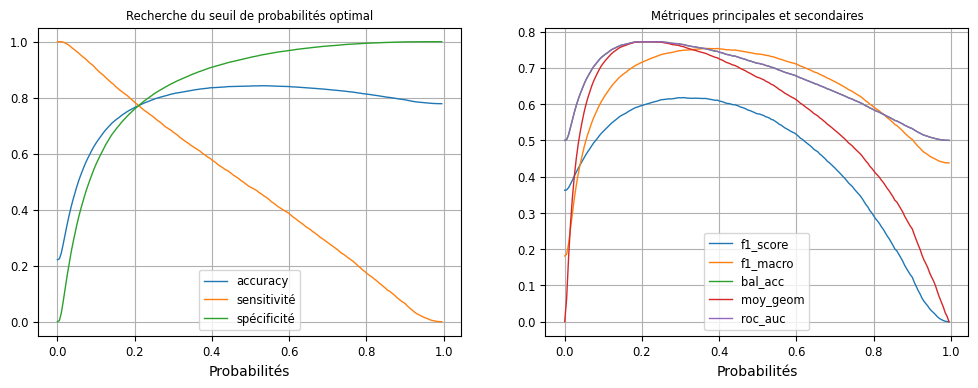

In [29]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_lr0)

In [30]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_lr0['Probabilités'].values
f = df_metrics_probas_lr0['sensitivité'].values
g = df_metrics_probas_lr0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_lr0, y_prob_thres_lr0) = thres_info[0]

In [31]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_lr0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_lr0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_lr0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.21

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25374  7516
1             2130  7217

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.77      0.84     32890
           1       0.49      0.77      0.60      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.77      0.72     42237
weighted avg       0.83      0.77      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.77      0.77      0.84      0.77      0.60     32890
          1       0.49      0.77      0.77      0.60      0.77      0.60      9347

avg / total       0.83      0.77      0.77      0.79      0.77      0.60     42237



- `accuracy, sensibilité, spécificité, moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.6`
- `f1-macro = 0.72`

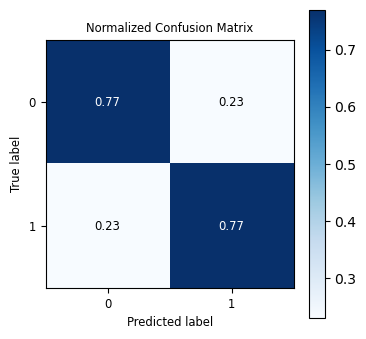

In [32]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

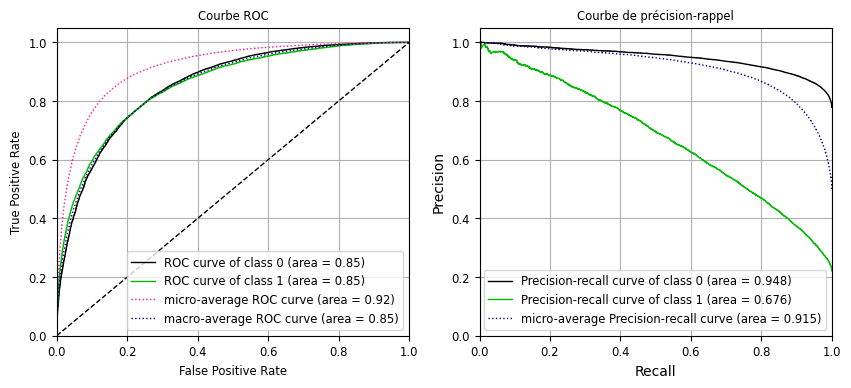

In [33]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

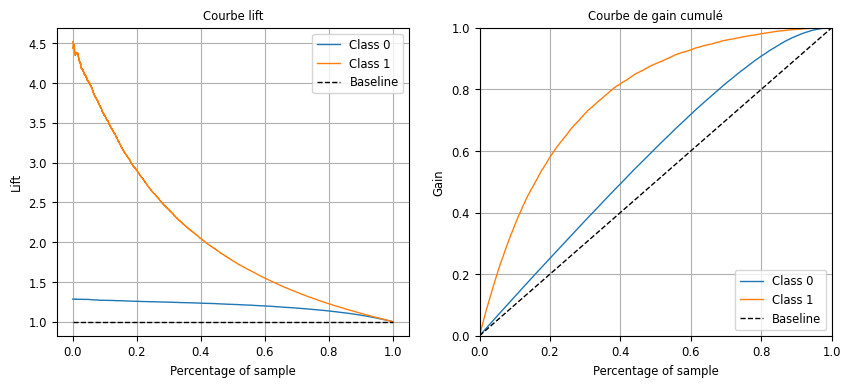

In [34]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = 'balanced'

In [35]:
# définition du modèle
clf_lr = LogisticRegression(class_weight='balanced')

In [36]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 'C':np.logspace(-3,3,7)}

In [37]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr1 = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr1.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [38]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1000.0, 'solver': 'lbfgs'}",0.725953,0.773905,0.773847,0.855871,0.142881,0.035843
1,"{'C': 100.0, 'solver': 'lbfgs'}",0.725953,0.773905,0.773847,0.855871,0.145252,0.040359
3,"{'C': 1000.0, 'solver': 'sag'}",0.725944,0.773898,0.773841,0.855871,1.123138,0.024311


In [39]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 100.0, 'solver': 'lbfgs'} 

Train Data Score: 0.7260538504250118
Test Data Score: 0.7255406038999133


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [40]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_lr1_train = error_metrics(gcv_lr1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_lr1_test = error_metrics(gcv_lr1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_lr1_train)
display("TEST", cv_lr1_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.725953,0.773905,0.773847,0.855871,0.088414,0.031556


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.72424,0.771678,0.771569,0.854632,0.02855,0.013031


In [41]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_lr1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.267960,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.677806,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.775228,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.292188,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.230378,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_lr1 = compute_metrics_with_probas(df_probas_test, y_test)

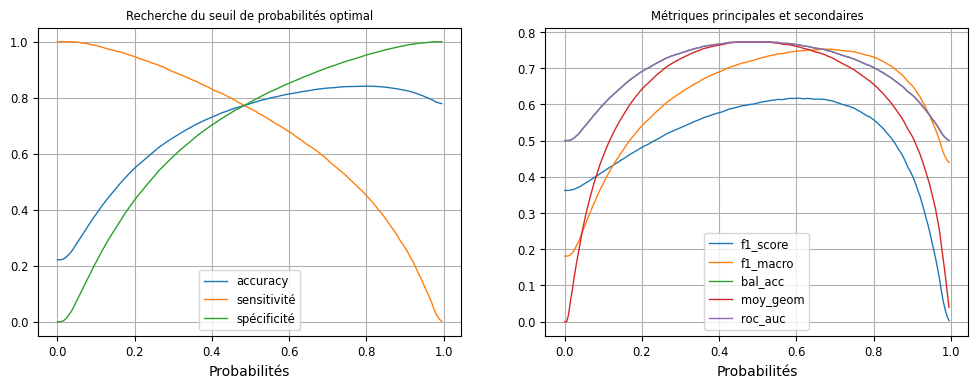

In [43]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_lr1)

In [44]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_lr1['Probabilités'].values
f = df_metrics_probas_lr1['sensitivité'].values
g = df_metrics_probas_lr1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_lr1, y_prob_thres_lr1) = thres_info[0]

In [45]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_lr1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_lr1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_lr1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.48

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25326  7564
1             2099  7248

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.77      0.84     32890
           1       0.49      0.78      0.60      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.77      0.72     42237
weighted avg       0.83      0.77      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.77      0.78      0.84      0.77      0.60     32890
          1       0.49      0.78      0.77      0.60      0.77      0.60      9347

avg / total       0.83      0.77      0.77      0.79      0.77      0.60     42237



- `0.77 < accuracy, sensibilité, spécificité, moyenne géométrique < 0.78`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.6`
- `f1-score = 0.72`

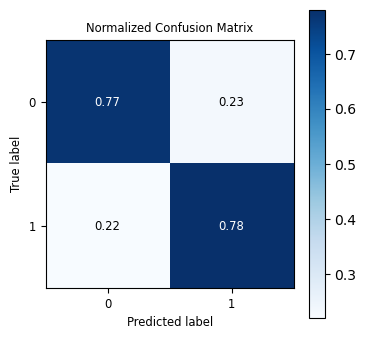

In [46]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

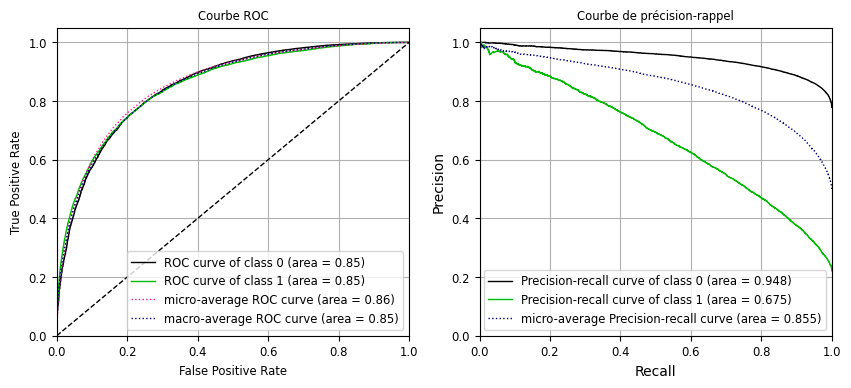

In [47]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

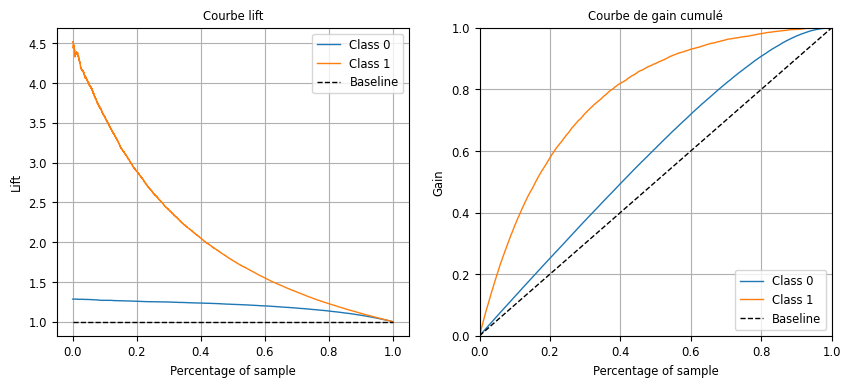

In [48]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [49]:
# définition du modèle
clf_lr = LogisticRegression()

In [50]:
# définition de l'intervalle pour le coefficient de pondération
weights = [float(x)/40 for x in range(40)]

In [51]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_lr = {'solver':[gcv_lr0.best_params_['solver']], 'C':[gcv_lr0.best_params_['C']], 'class_weight': [{0:x, 1:1.0-x} for x in weights]} 

In [52]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr2 = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit="f1", n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1],
                         'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.025, 1: 0.975},
                                          {0: 0.05, 1: 0.95},
                                          {0: 0.075, 1: 0.925},
                                          {0: 0.1, 1: 0.9},
                                          {0: 0.125, 1: 0.875},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.175, 1: 0.825},
                                          {0: 0.2, 1: 0.8},
                                          {0: 0.225, 1: 0.775},
                                          {0: 0.25, 1: 0.75},
                                          {0: 0.275, 1: 0.725},
                                          {0: 0.3, 1: 0.7},
                                          {0: 0.325, 1: 0.675},
                                          {0: 0.35, 1: 0.65},
                                          {0: 0.37...
                                          {0: 0.55, 1: 0.44999999999999996},
                                          {0: 0.575, 1: 0.42500000000000004},
                                          {0: 0.6, 1: 0.4},
                                          {0: 0.625, 1: 0.375},
                                          {0: 0.65, 1: 0.35},
                                          {0: 0.675, 1: 0.32499999999999996},
                                          {0: 0.7, 1: 0.30000000000000004},
                                          {0: 0.725, 1: 0.275}, ...],
                         'solver': ['liblinear']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [53]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 0.1, 'class_weight': {0: 0.375, 1: 0.625}, 'solver': 'liblinear'}",0.752934,0.749842,0.735324,0.855736,0.651429,0.045007
2,"{'C': 0.1, 'class_weight': {0: 0.35, 1: 0.65}, 'solver': 'liblinear'}",0.752279,0.755809,0.745015,0.855763,0.567022,0.056070
3,"{'C': 0.1, 'class_weight': {0: 0.4, 1: 0.6}, 'solver': 'liblinear'}",0.752082,0.743326,0.724825,0.855704,0.626242,0.041025


In [54]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 0.1, 'class_weight': {0: 0.375, 1: 0.625}, 'solver': 'liblinear'} 

Train Data Score: 0.7530216020085748
Test Data Score: 0.7524514398315513


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [55]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_lr2_train = error_metrics(gcv_lr2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_lr2_test = error_metrics(gcv_lr2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_lr2_train)
display("TEST", cv_lr2_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.752934,0.749842,0.735324,0.855736,0.226169,0.025393


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.752062,0.749375,0.734891,0.8545,0.061458,0.010886


In [56]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_lr2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.153318,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.487634,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.601475,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.163549,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.121288,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_lr2 = compute_metrics_with_probas(df_probas_test, y_test)

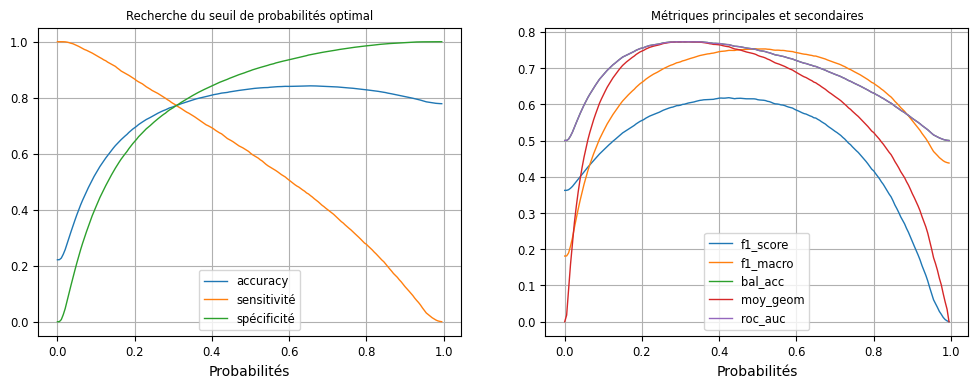

In [58]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_lr2)

In [59]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_lr2['Probabilités'].values
f = df_metrics_probas_lr2['sensitivité'].values
g = df_metrics_probas_lr2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_lr2, y_prob_thres_lr2) = thres_info[0]

In [60]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_lr2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_lr2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_lr2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.305

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25312  7578
1             2100  7247

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.77      0.84     32890
           1       0.49      0.78      0.60      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.77      0.72     42237
weighted avg       0.83      0.77      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.77      0.78      0.84      0.77      0.60     32890
          1       0.49      0.78      0.77      0.60      0.77      0.60      9347

avg / total       0.83      0.77      0.77      0.79      0.77      0.60     42237



- `0.77 < accuracy, sensibilité, spécificité, moyenne géométrique < 0.78`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.6`
- `f1-macro = 0.72`

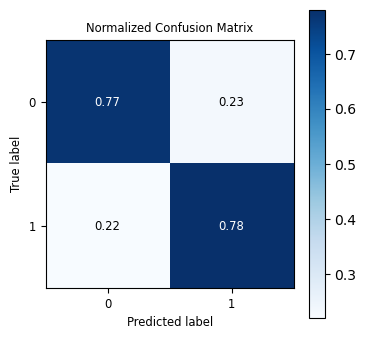

In [61]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

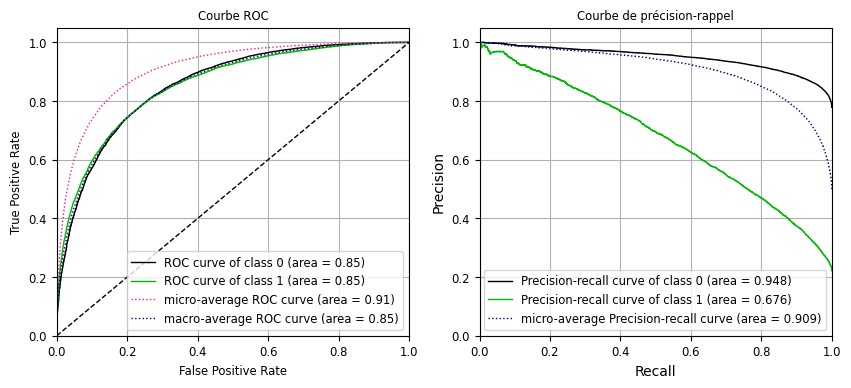

In [62]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

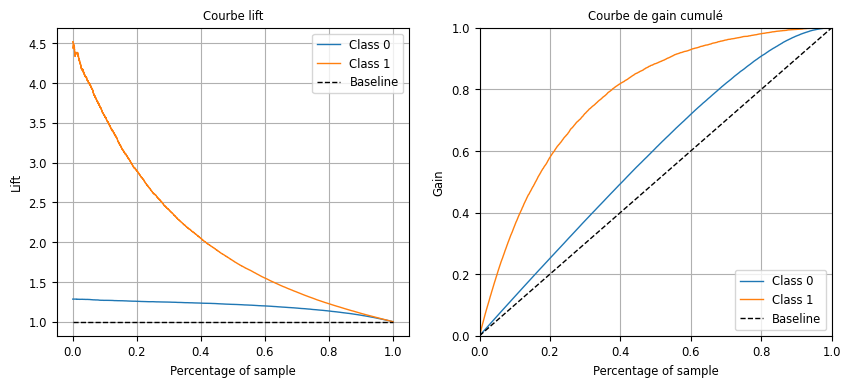

In [63]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [64]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_lr = pd.DataFrame(data=[cv_lr0_train.values[0], cv_lr0_test.values[0], cv_lr1_train.values[0], cv_lr1_test.values[0], 
                           cv_lr2_train.values[0], cv_lr2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'], 
                     index=['lr0 : train', 'lr0 : test', 'lr1 : train', 'lr1 : test', 'lr2 : train', 'lr2 : test'])
cv_lr.index.name='Cross validation'
cv_lr.to_csv('../scores/cv_lr_'+param_ru+'.csv')
cv_lr

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
lr0 : train,0.736005,0.710580,0.671261,0.855555,0.226933,0.026132
lr0 : test,0.738415,0.713246,0.675124,0.854329,0.076316,0.011583
lr1 : train,0.725953,0.773905,0.773847,0.855871,0.088414,0.031556
lr1 : test,0.724240,0.771678,0.771569,0.854632,0.028550,0.013031
lr2 : train,0.752934,0.749842,0.735324,0.855736,0.226169,0.025393
lr2 : test,0.752062,0.749375,0.734891,0.854500,0.061458,0.010886


In [65]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_lr = {'lr0' : df_metrics_probas_lr0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_lr0],
           'lr1' : df_metrics_probas_lr1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_lr1],
           'lr2' : df_metrics_probas_lr2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_lr2]}

test_lr = pd.DataFrame(data=[data_lr['lr0'], data_lr['lr1'], data_lr['lr2']], 
                       columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                       index=['lr1', 'lr2', 'lr3'])
test_lr.index.name='Final Test'
test_lr.to_csv('../scores/test_lr_'+param_ru+'.csv')
test_lr

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
lr1,0.599419,0.719850,0.771800,0.771800,0.771800
lr2,0.600025,0.719908,0.772729,0.772724,0.772729
lr3,0.599619,0.719564,0.772462,0.772457,0.772462


### Forêts Aléatoires

#### class_weight = None

In [66]:
# définition du modèle
clf_rf = RandomForestClassifier(class_weight=None)

In [67]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_rf = [{'n_estimators':np.arange(150,210,25), 'min_samples_leaf':np.arange(1,4,1), 'max_features':['sqrt', 'log2']}]

In [68]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf0 = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf0.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': array([1, 2, 3]),
                          'n_estimators': array([150, 175, 200])}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [69]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150}",0.753148,0.724370,0.687247,0.871560,19.968378,2.616166
2,"{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}",0.752112,0.723245,0.685645,0.872037,25.760721,3.437459
3,"{'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 200}",0.751996,0.722662,0.684451,0.872468,18.650929,2.344495


In [70]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150} 

Train Data Score: 0.9566813284639404
Test Data Score: 0.7571099011595768


- la méthode **fait l'objet d'un fort sur-apprentissage** (score=f1_macro)

In [71]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_rf0_train = error_metrics(gcv_rf0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_rf0_test = error_metrics(gcv_rf0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_rf0_train)
display("TEST", cv_rf0_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.752474,0.723552,0.686018,0.871722,10.69612,1.778577


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.749087,0.719265,0.679189,0.866143,4.266405,0.656884


In [72]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_rf0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.128816,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.373395,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.284617,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.064223,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.212270,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_rf0 = compute_metrics_with_probas(df_probas_test, y_test)

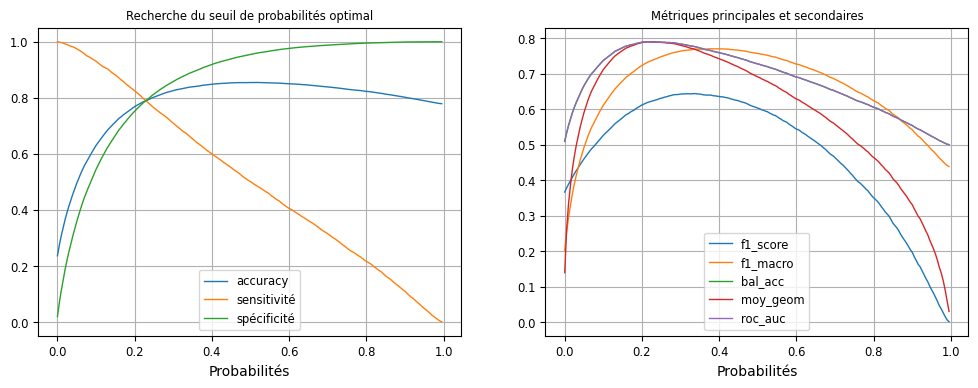

In [74]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_rf0)

In [75]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_rf0['Probabilités'].values
f = df_metrics_probas_rf0['sensitivité'].values
g = df_metrics_probas_rf0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_rf0, y_prob_thres_rf0) = thres_info[0]

In [76]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_rf0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_rf0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_rf0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.225

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25819  7071
1             1923  7424

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     32890
           1       0.51      0.79      0.62      9347

    accuracy                           0.79     42237
   macro avg       0.72      0.79      0.74     42237
weighted avg       0.84      0.79      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.79      0.79      0.85      0.79      0.62     32890
          1       0.51      0.79      0.79      0.62      0.79      0.62      9347

avg / total       0.84      0.79      0.79      0.80      0.79      0.62     42237



- `accuracy, sensibilité, spécificité, moyenne géométrique = 0.79`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.62`
- `f1-macro = 0.74`

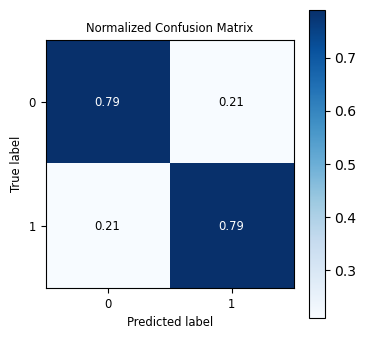

In [77]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

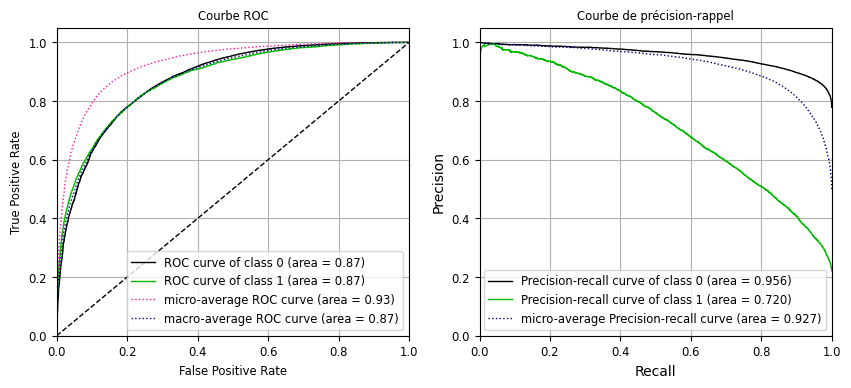

In [78]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

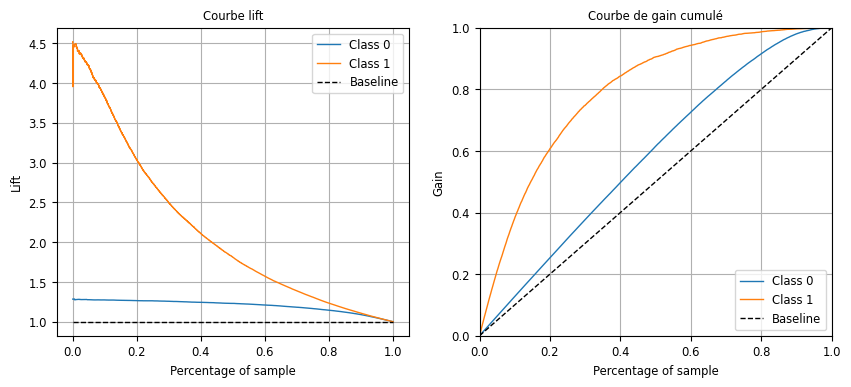

In [79]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = 'balanced'

In [80]:
# définition du modèle
clf_rf = RandomForestClassifier(class_weight='balanced')

In [81]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_rf = [{'n_estimators':np.arange(150,210,25), 'min_samples_leaf':np.arange(1,4,1), 'max_features':['sqrt', 'log2']}]

In [82]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf1 = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf1.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': array([1, 2, 3]),
                          'n_estimators': array([150, 175, 200])}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [83]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150}",0.769661,0.760266,0.744216,0.873050,18.036367,2.380426
2,"{'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 200}",0.769247,0.759631,0.743370,0.873080,18.216418,2.322214
3,"{'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 175}",0.769227,0.759874,0.743780,0.873109,19.871095,2.325262


In [84]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150} 

Train Data Score: 0.9494103866188519
Test Data Score: 0.7689205348471703


- la méthode **fait l'objet d'un fort sur-apprentissage** (score=f1_macro)

In [85]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_rf1_train = error_metrics(gcv_rf1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_rf1_test = error_metrics(gcv_rf1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_rf1_train)
display("TEST", cv_rf1_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.769295,0.759949,0.743868,0.872745,10.062423,1.76209


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.764195,0.753714,0.735949,0.867379,3.984384,0.647466


In [86]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_rf1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.128778,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.478594,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.351645,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.150025,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.242836,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_rf1 = compute_metrics_with_probas(df_probas_test, y_test)

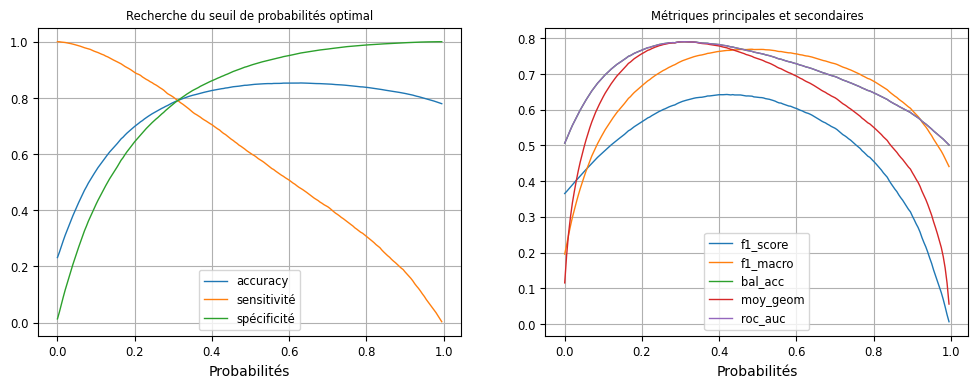

In [88]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_rf1)

In [89]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_rf1['Probabilités'].values
f = df_metrics_probas_rf1['sensitivité'].values
g = df_metrics_probas_rf1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_rf1, y_prob_thres_rf1) = thres_info[0]

In [90]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_rf1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_rf1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_rf1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.31

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25951  6939
1             1940  7407

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     32890
           1       0.52      0.79      0.63      9347

    accuracy                           0.79     42237
   macro avg       0.72      0.79      0.74     42237
weighted avg       0.84      0.79      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.79      0.79      0.85      0.79      0.63     32890
          1       0.52      0.79      0.79      0.63      0.79      0.63      9347

avg / total       0.84      0.79      0.79      0.80      0.79      0.63     42237



- `accuracy, sensibilité, spécificité, moyenne géométrique = 0.79`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.63`
- `f1-macro = 0.74`

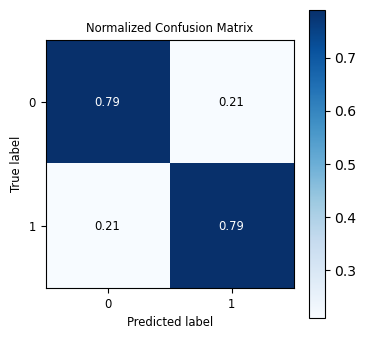

In [91]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

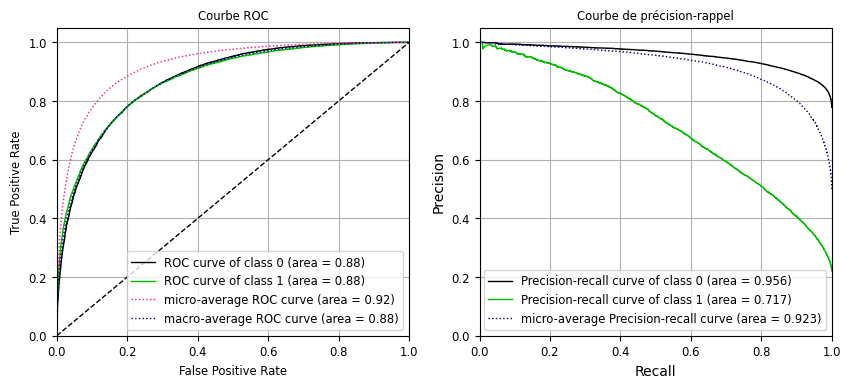

In [92]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

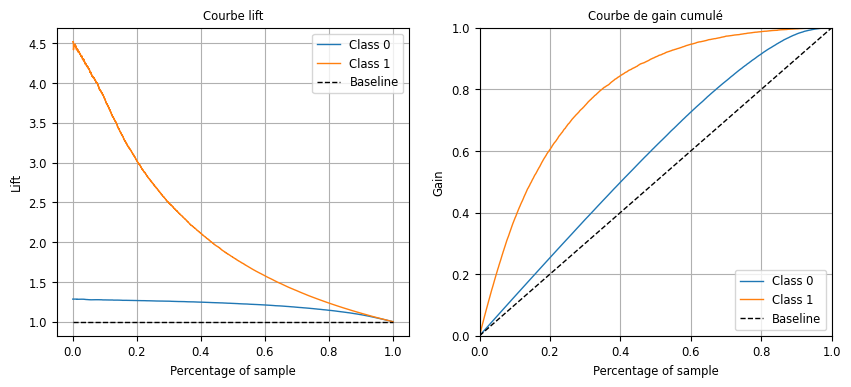

In [93]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [94]:
# définition du modèle
clf_rf = RandomForestClassifier()

In [95]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.45,0.55,11)

In [96]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_rf = [{'n_estimators':[gcv_rf0.best_params_['n_estimators']], 'min_samples_leaf':[gcv_rf0.best_params_['min_samples_leaf']], 
                  'max_features':[gcv_rf0.best_params_['max_features']], 'class_weight':[{0:x, 1:1.0-x} for x in weights]}]

In [97]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf2 = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit="f1", n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': [{0: 0.45, 1: 0.55},
                                           {0: 0.46, 1: 0.54},
                                           {0: 0.47000000000000003, 1: 0.53},
                                           {0: 0.48000000000000004, 1: 0.52},
                                           {0: 0.49000000000000005, 1: 0.51},
                                           {0: 0.5, 1: 0.5}, {0: 0.51, 1: 0.49},
                                           {0: 0.52, 1: 0.48},
                                           {0: 0.53, 1: 0.47},
                                           {0: 0.54, 1: 0.45999999999999996},
                                           {0: 0.55, 1: 0.44999999999999996}],
                          'max_features': ['sqrt'], 'min_samples_leaf': [2],
                          'n_estimators': [150]}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [98]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'class_weight': {0: 0.45, 1: 0.55}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150}",0.754263,0.727065,0.692150,0.871873,18.602043,2.661107
2,"{'class_weight': {0: 0.46, 1: 0.54}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150}",0.754108,0.726449,0.690966,0.871255,19.085891,2.774403
3,"{'class_weight': {0: 0.47000000000000003, 1: 0.53}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150}",0.753943,0.726072,0.690291,0.872074,20.206037,2.898215


In [99]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'class_weight': {0: 0.45, 1: 0.55}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 150} 

Train Data Score: 0.9644147121263481
Test Data Score: 0.7589116499275291


- la méthode **fait l'objet d'un fort sur-apprentissage** (score=f1_macro)

In [100]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_rf2_train = error_metrics(gcv_rf2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_rf2_test = error_metrics(gcv_rf2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_rf2_train)
display("TEST", cv_rf2_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.754576,0.727326,0.692459,0.871809,10.781559,1.804275


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.751039,0.722398,0.684585,0.866687,4.248944,0.693122


In [101]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_rf2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.066193,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.410449,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.224385,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.061402,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.161104,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_rf2 = compute_metrics_with_probas(df_probas_test, y_test)

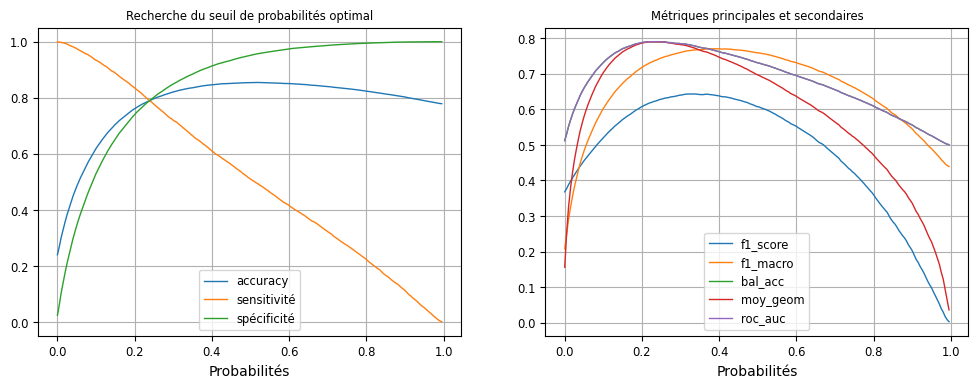

In [103]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_rf2)

In [104]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_rf2['Probabilités'].values
f = df_metrics_probas_rf2['sensitivité'].values
g = df_metrics_probas_rf2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_rf2, y_prob_thres_rf2) = thres_info[0]

In [105]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_rf2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_rf2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_rf2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.235

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25841  7049
1             1926  7421

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     32890
           1       0.51      0.79      0.62      9347

    accuracy                           0.79     42237
   macro avg       0.72      0.79      0.74     42237
weighted avg       0.84      0.79      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.79      0.79      0.85      0.79      0.62     32890
          1       0.51      0.79      0.79      0.62      0.79      0.62      9347

avg / total       0.84      0.79      0.79      0.80      0.79      0.62     42237



- `accuracy, sensibilité, spécificité, moyenne géométrique = 0.79`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.62`
- `f1-macro = 0.74`

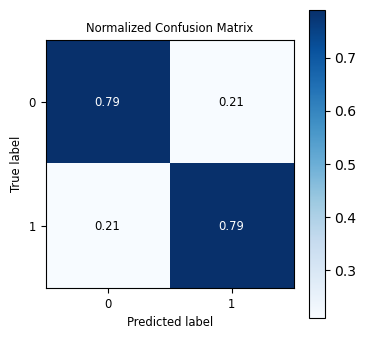

In [106]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

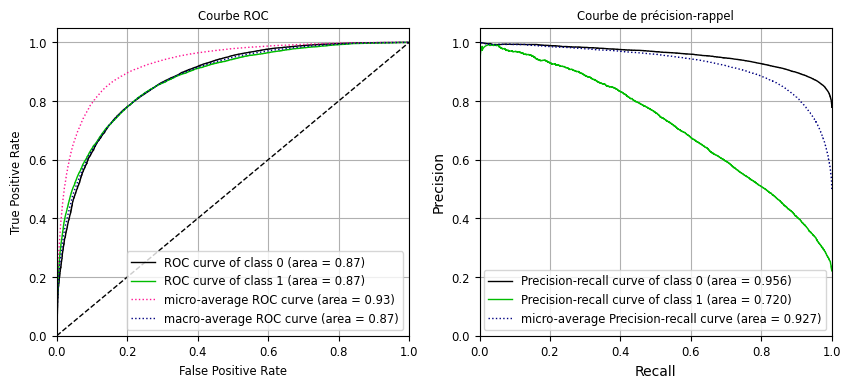

In [107]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

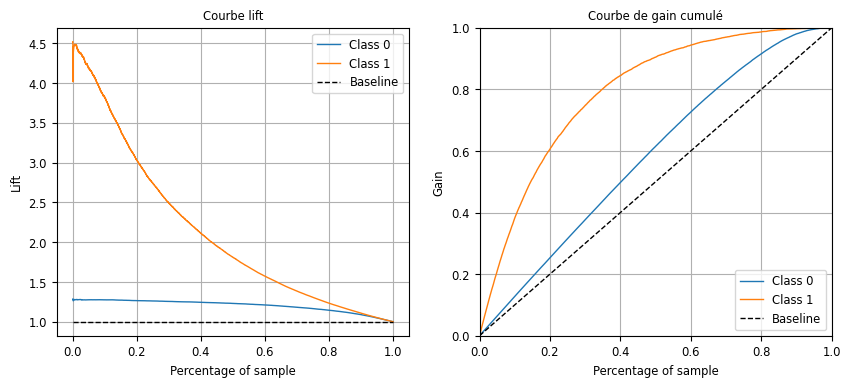

In [108]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [109]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_rf = pd.DataFrame(data=[cv_rf0_train.values[0], cv_rf0_test.values[0], cv_rf1_train.values[0], cv_rf1_test.values[0], 
                           cv_rf2_train.values[0], cv_rf2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'],
                     index=['rf0 : train', 'rf0 : test', 'rf1 : train', 'rf1 : test', 'rf2 : train', 'rf2 : test'])
cv_rf.index.name='Cross validation'
cv_rf.to_csv('../scores/cv_rf_'+param_ru+'.csv')
cv_rf

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
rf0 : train,0.752474,0.723552,0.686018,0.871722,10.696120,1.778577
rf0 : test,0.749087,0.719265,0.679189,0.866143,4.266405,0.656884
rf1 : train,0.769295,0.759949,0.743868,0.872745,10.062423,1.762090
rf1 : test,0.764195,0.753714,0.735949,0.867379,3.984384,0.647466
rf2 : train,0.754576,0.727326,0.692459,0.871809,10.781559,1.804275
rf2 : test,0.751039,0.722398,0.684585,0.866687,4.248944,0.693122


In [110]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_rf = {'rf0' : df_metrics_probas_rf0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_rf0],
           'rf1' : df_metrics_probas_rf1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_rf1],
           'rf2' : df_metrics_probas_rf2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_rf2]}

test_rf = pd.DataFrame(data=[data_rf['rf0'], data_rf['rf1'], data_rf['rf2']], 
                       columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                       index=['rf0', 'rf1', 'rf2'])
test_rf.index.name='Final Test'
test_rf.to_csv('../scores/test_rf_'+param_ru+'.csv')
test_rf

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
rf0,0.622767,0.737215,0.789638,0.789625,0.789638
rf1,0.625248,0.739583,0.790735,0.790734,0.790735
rf2,0.623168,0.737603,0.789812,0.789801,0.789812


### Séparateurs à Vaste Marge

#### class_weight = None

In [21]:
# définition du modèle
clf_svm = SVC(probability=True, class_weight=None)

In [22]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_svm = {'kernel':['rbf'], 'gamma':[1], 'C':[1]}

In [23]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm0 = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=2, return_train_score=True)

# entraînement du modèle
gcv_svm0.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1], 'gamma': [1], 'kernel': ['rbf']}, refit='f1',
             return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [24]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                           'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.728744,0.698918,0.649932,0.817587,2035.954804,270.057431


In [25]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1, 'gamma': 1, 'kernel': 'rbf'} 

Train Data Score: 0.8503746931259413
Test Data Score: 0.7438818957481934


- la méthode **fait l'objet d'un fort sur-apprentissage** (score=f1_macro)

In [66]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_svm0_train = error_metrics(gcv_svm0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_svm0_test = error_metrics(gcv_svm0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_svm0_train)
display("TEST", cv_svm0_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.735705,0.706028,0.660646,0.820864,3729.911129,231.450282


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.710139,0.679943,0.619297,0.816536,489.255598,47.623551


In [67]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_svm0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.088250,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.170929,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.182065,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.089823,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.115985,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_svm0 = compute_metrics_with_probas(df_probas_test, y_test)

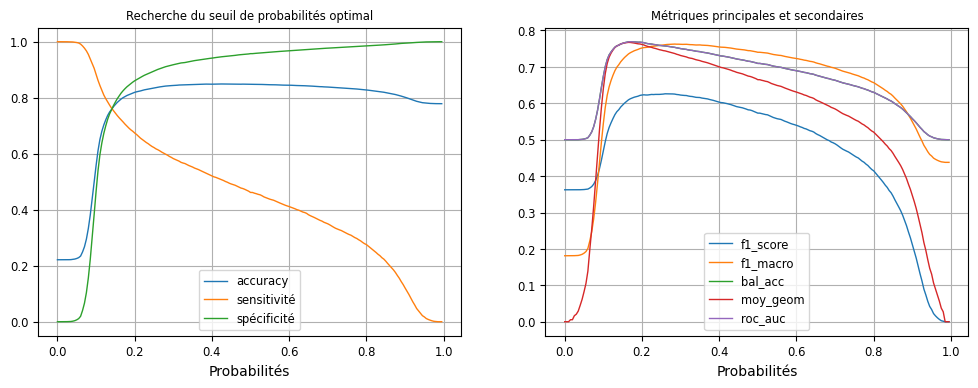

In [29]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_svm0)

In [30]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_svm0['Probabilités'].values
f = df_metrics_probas_svm0['sensitivité'].values
g = df_metrics_probas_svm0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_svm0, y_prob_thres_svm0) = thres_info[0]

In [31]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_svm0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_svm0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_svm0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.14

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24881  8009
1             2216  7131

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.76      0.83     32890
           1       0.47      0.76      0.58      9347

    accuracy                           0.76     42237
   macro avg       0.69      0.76      0.71     42237
weighted avg       0.82      0.76      0.77     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.76      0.76      0.83      0.76      0.58     32890
          1       0.47      0.76      0.76      0.58      0.76      0.58      9347

avg / total       0.82      0.76      0.76      0.77      0.76      0.58     42237



- `accuracy, sensibilité, spécificité, moyenne géométrique = 0.76`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.58`
- `f1-macro = 0.71`

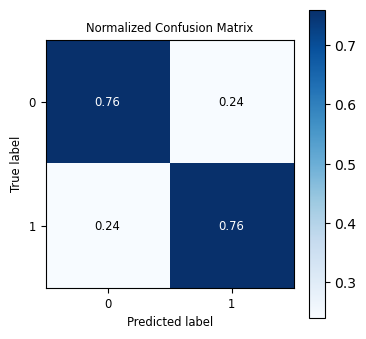

In [32]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

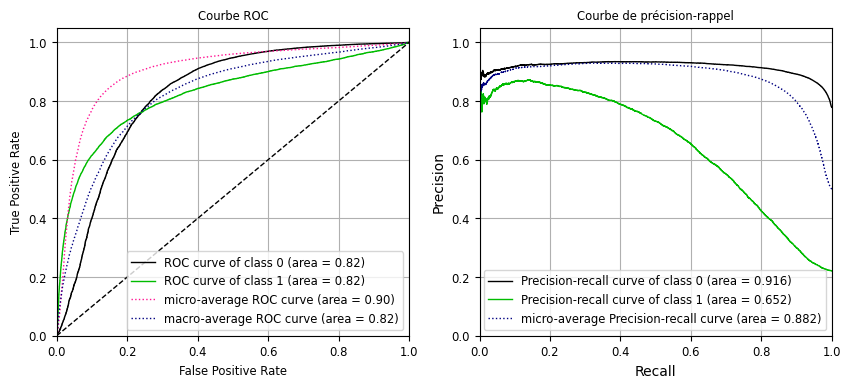

In [33]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

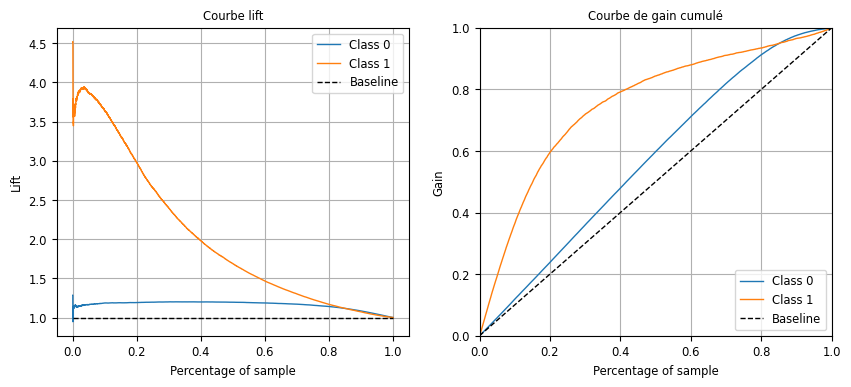

In [34]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = 'balanced'

In [35]:
# définition du modèle
clf_svm = SVC(probability=True, class_weight='balanced')

In [36]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_svm = {'kernel':[gcv_svm0.best_params_['kernel']], 'gamma':[gcv_svm0.best_params_['gamma']], 'C':[gcv_svm0.best_params_['C']]} 

In [37]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm1 = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=2, return_train_score=True)

# entraînement du modèle
gcv_svm1.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(class_weight='balanced', probability=True),
             n_jobs=-1, param_grid={'C': [1], 'gamma': [1], 'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [38]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                           'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.741159,0.757056,0.750968,0.835084,1707.78365,285.329496


In [39]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1, 'gamma': 1, 'kernel': 'rbf'} 

Train Data Score: 0.8634022550025557
Test Data Score: 0.745960053276692


- la méthode **fait l'objet d'un fort sur-apprentissage** (score=f1_macro)

In [40]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_svm1_train = error_metrics(gcv_svm1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_svm1_test = error_metrics(gcv_svm1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_svm1_train)
display("TEST", cv_svm1_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.745352,0.765264,0.760804,0.840307,3581.437846,256.37813


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.734382,0.742264,0.731892,0.828032,508.557914,50.768714


In [41]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_svm1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.128859,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.209351,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.422146,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.073256,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.103965,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_svm1 = compute_metrics_with_probas(df_probas_test, y_test)

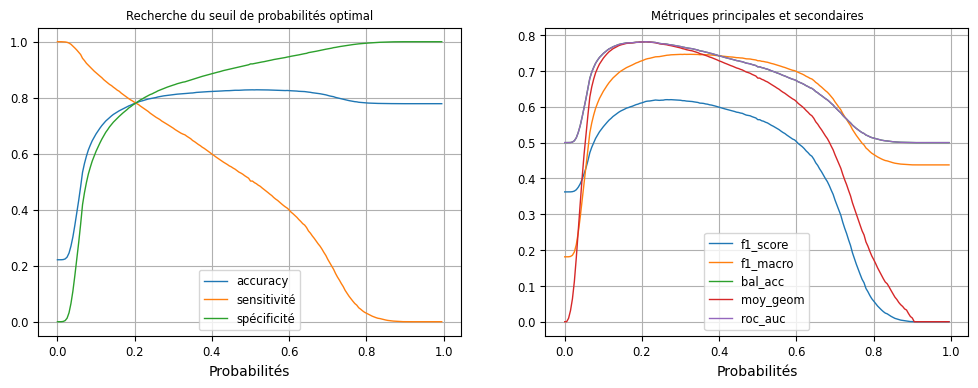

In [43]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_svm1)

In [44]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_svm1['Probabilités'].values
f = df_metrics_probas_svm1['sensitivité'].values
g = df_metrics_probas_svm1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_svm1, y_prob_thres_svm1) = thres_info[0]

In [45]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_svm1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_svm1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_svm1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.2

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25597  7293
1             2027  7320

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     32890
           1       0.50      0.78      0.61      9347

    accuracy                           0.78     42237
   macro avg       0.71      0.78      0.73     42237
weighted avg       0.83      0.78      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.78      0.78      0.85      0.78      0.61     32890
          1       0.50      0.78      0.78      0.61      0.78      0.61      9347

avg / total       0.83      0.78      0.78      0.79      0.78      0.61     42237



- `accuracy, sensibilité, spécificité, moyenne géométrique = 0.78`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.61`
- `f1-macro = 0.73`

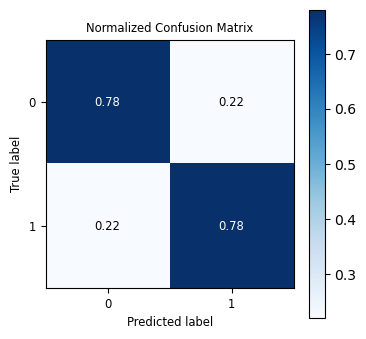

In [46]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

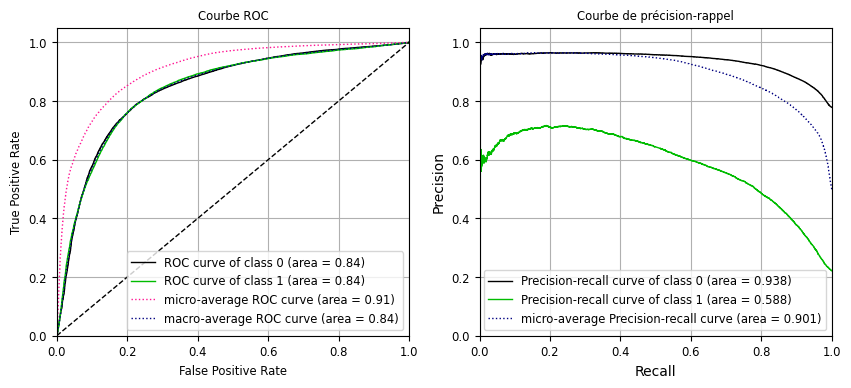

In [47]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

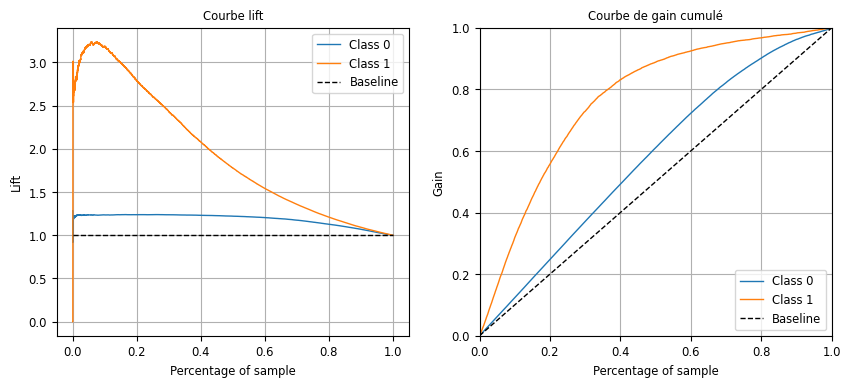

In [48]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [49]:
# définition du modèle
clf_svm = SVC(probability=True)

In [50]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.5,0.55,2)

In [51]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_svm = {'kernel':[gcv_svm0.best_params_['kernel']], 'gamma':[gcv_svm0.best_params_['gamma']], 
                  'C':[gcv_svm0.best_params_['C']], 'class_weight': [{0:x, 1:1.0-x} for x in weights]} 

In [52]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm2 = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=2, return_train_score=True)

# entraînement du modèle
gcv_svm2.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1],
                         'class_weight': [{0: 0.5, 1: 0.5},
                                          {0: 0.55, 1: 0.44999999999999996}],
                         'gamma': [1], 'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [53]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                           'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'}",0.701158,0.669238,0.597887,0.820400,1600.249954,289.095426
2,"{'C': 1, 'class_weight': {0: 0.55, 1: 0.44999999999999996}, 'gamma': 1, 'kernel': 'rbf'}",0.680555,0.650002,0.561225,0.813677,1669.671057,291.243226


In [54]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1, 'class_weight': {0: 0.5, 1: 0.5}, 'gamma': 1, 'kernel': 'rbf'} 

Train Data Score: 0.7907643164979168
Test Data Score: 0.7272661287615814


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [55]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_svm2_train = error_metrics(gcv_svm2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_svm2_test = error_metrics(gcv_svm2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_svm2_train)
display("TEST", cv_svm2_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.712821,0.680263,0.616596,0.823145,2785.07551,222.142068


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.670719,0.642357,0.549123,0.819185,393.277518,47.157206


In [56]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_svm2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.101849,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.151868,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.161934,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.103225,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.118031,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_svm2 = compute_metrics_with_probas(df_probas_test, y_test)

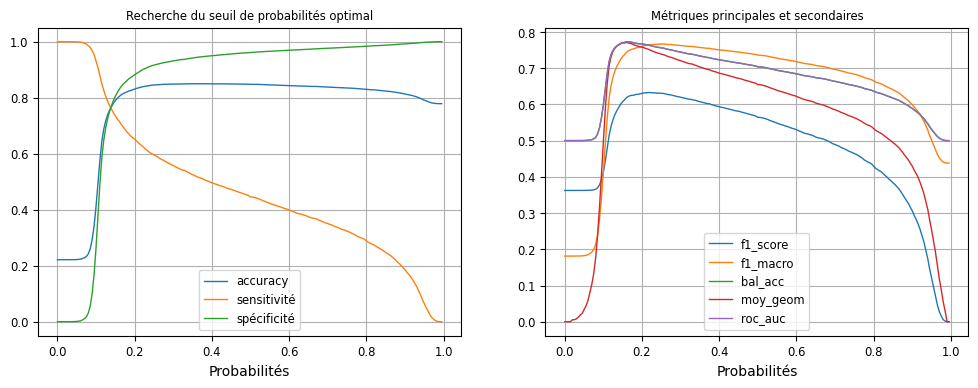

In [58]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_svm2)

In [59]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_svm2['Probabilités'].values
f = df_metrics_probas_svm2['sensitivité'].values
g = df_metrics_probas_svm2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_svm2, y_prob_thres_svm2) = thres_info[0]

In [60]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_svm2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_svm2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_svm2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.135

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24701  8189
1             2135  7212

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.75      0.83     32890
           1       0.47      0.77      0.58      9347

    accuracy                           0.76     42237
   macro avg       0.69      0.76      0.70     42237
weighted avg       0.82      0.76      0.77     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.75      0.77      0.83      0.76      0.58     32890
          1       0.47      0.77      0.75      0.58      0.76      0.58      9347

avg / total       0.82      0.76      0.77      0.77      0.76      0.58     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.76`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.58`
- `f1-macro = 0.7`

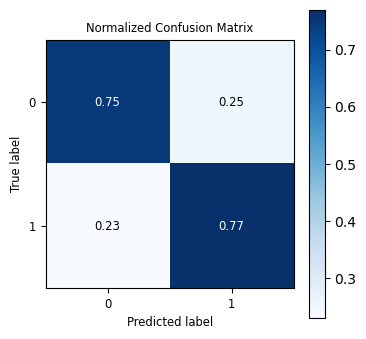

In [61]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

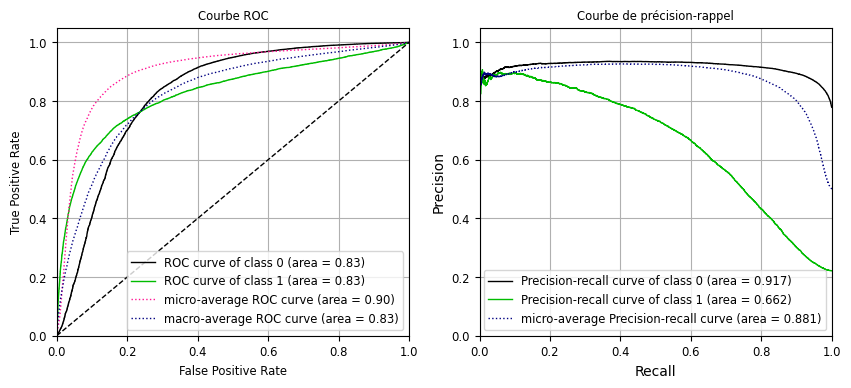

In [62]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

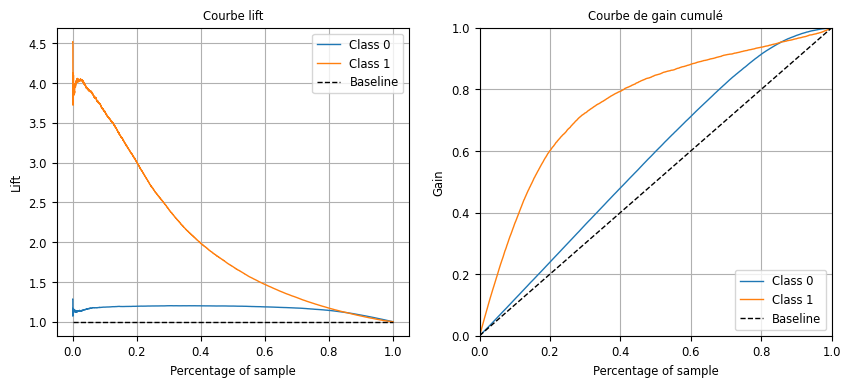

In [63]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [64]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_svm = pd.DataFrame(data=[cv_svm0_train.values[0], cv_svm0_test.values[0], cv_svm1_train.values[0], cv_svm1_test.values[0], 
                            cv_svm2_train.values[0], cv_svm2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'],
                     index=['svm0 : train', 'svm0 : test', 'svm1 : train', 'svm1 : test', 'svm2 : train', 'svm2 : test'])
cv_svm.index.name='Cross validation'
cv_svm.to_csv('../scores/cv_svm_'+param_ru+'.csv')
cv_svm

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
svm0 : train,0.735705,0.706028,0.660646,0.820864,4061.798520,231.640645
svm0 : test,0.710139,0.679943,0.619297,0.816536,535.839822,47.771947
svm1 : train,0.745352,0.765264,0.760804,0.840307,3581.437846,256.378130
svm1 : test,0.734382,0.742264,0.731892,0.828032,508.557914,50.768714
svm2 : train,0.712821,0.680263,0.616596,0.823145,2785.075510,222.142068
svm2 : test,0.670719,0.642357,0.549123,0.819185,393.277518,47.157206


In [65]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_svm = {'svm0' : df_metrics_probas_svm0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_svm0],
            'svm1' : df_metrics_probas_svm1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_svm1],
            'svm2' : df_metrics_probas_svm2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_svm2]}

test_svm = pd.DataFrame(data=[data_svm['svm0'], data_svm['svm1'], data_svm['svm2']], 
                        columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                        index=['svm0', 'svm1', 'svm2'])
test_svm.index.name='Final Test'
test_svm.to_csv('../scores/test_svm_'+param_ru+'.csv')
test_svm

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
svm0,0.582431,0.705989,0.759705,0.759698,0.759705
svm1,0.611018,0.728502,0.780700,0.780696,0.780700
svm2,0.582835,0.704989,0.761302,0.761232,0.761302


### K-plus proches voisins

In [111]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

In [112]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_knn = {'n_neighbors':np.arange(20,30,1), 'metric':['minkowski','manhattan'], 'p':[1, 2]}

In [113]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_knn = GridSearchCV(clf_knn, param_grid=param_grid_knn, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': [1, 2]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [114]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_knn.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'metric': 'manhattan', 'n_neighbors': 23, 'p': 2}",0.746068,0.717465,0.677893,0.86069,0.411957,162.012367
1,"{'metric': 'manhattan', 'n_neighbors': 23, 'p': 1}",0.746068,0.717465,0.677893,0.86069,0.349612,160.179250
1,"{'metric': 'minkowski', 'n_neighbors': 23, 'p': 1}",0.746068,0.717465,0.677893,0.86069,0.346971,151.452132


In [115]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_knn.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'metric': 'minkowski', 'n_neighbors': 23, 'p': 1} 

Train Data Score: 0.7633560405270546
Test Data Score: 0.7484880630278739


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [116]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_knn_train = error_metrics(gcv_knn.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_knn_test = error_metrics(gcv_knn.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_knn_train)
display("TEST", cv_knn_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.746068,0.717465,0.677893,0.86069,0.461322,90.935455


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.737466,0.707912,0.663372,0.854626,0.056912,10.791359


In [117]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_knn.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.217391,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.347826,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.217391,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.043478,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.043478,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [118]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_knn = compute_metrics_with_probas(df_probas_test, y_test)

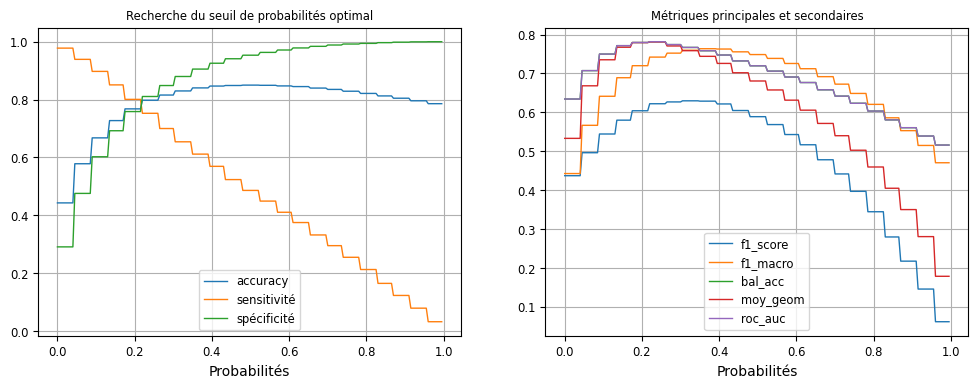

In [119]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_knn)

In [120]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_knn['Probabilités'].values
f = df_metrics_probas_knn['sensitivité'].values
g = df_metrics_probas_knn['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_knn, y_prob_thres_knn) = thres_info[0]

In [121]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_knn.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_knn).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_knn)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.215

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24944  7946
1             1864  7483

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.76      0.84     32890
           1       0.48      0.80      0.60      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.78      0.72     42237
weighted avg       0.83      0.77      0.78     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.76      0.80      0.84      0.78      0.60     32890
          1       0.48      0.80      0.76      0.60      0.78      0.61      9347

avg / total       0.83      0.77      0.79      0.78      0.78      0.61     42237



- `0.76 < accuracy, sensibilité, spécificité, moyenne géométrique < 0.8`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.6`
- `f1-macro = 0.72`

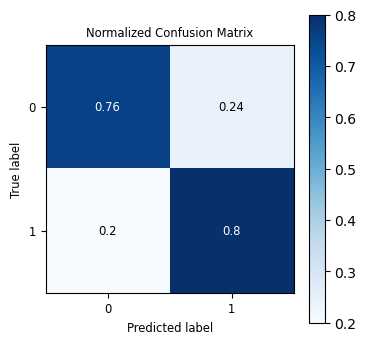

In [122]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

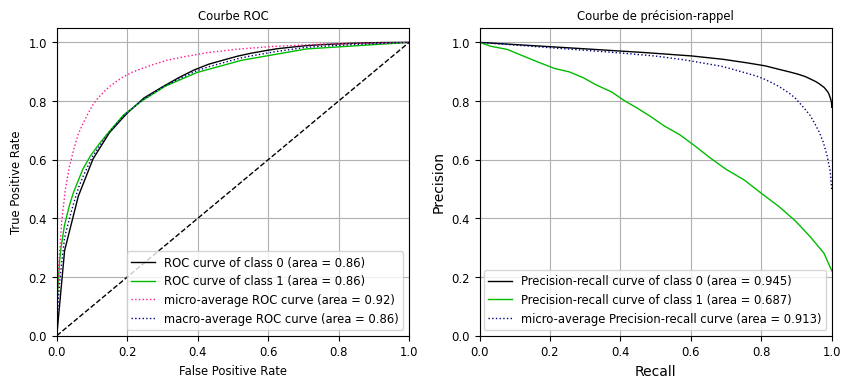

In [123]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

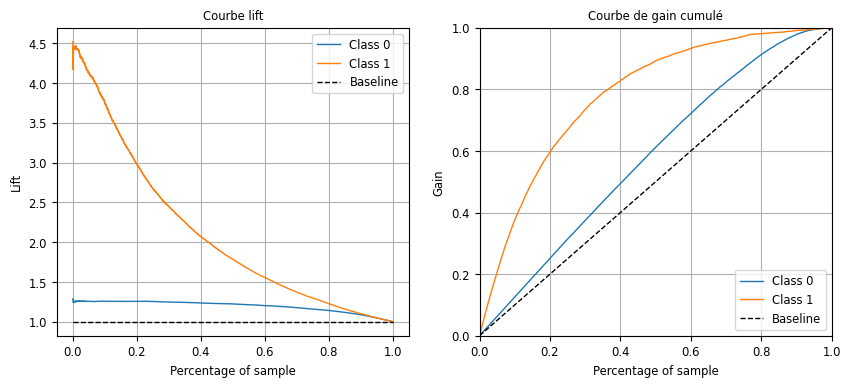

In [124]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [125]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_knn = pd.DataFrame(data=[cv_knn_train.values[0], cv_knn_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'], 
                     index=['knn : train', 'knn : test'])
cv_knn.index.name='Cross validation'
cv_knn.to_csv('../scores/cv_knn_'+param_ru+'.csv')
cv_knn

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
knn : train,0.746068,0.717465,0.677893,0.860690,0.461322,90.935455
knn : test,0.737466,0.707912,0.663372,0.854626,0.056912,10.791359


In [126]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_knn = {'knn' : df_metrics_probas_knn[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_knn]}

test_knn = pd.DataFrame(data=[data_knn['knn']], 
                        columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                        index=['knn'])
test_knn.index.name='Final Test'
test_knn.to_csv('../scores/test_knn_'+param_ru+'.csv')
test_knn

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
knn,0.604052,0.719863,0.779492,0.779207,0.779492


### Arbres de décision

#### class_weight = None

In [127]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight=None)

In [128]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['entropy','gini'], 'max_depth':np.arange(6,12,1)}

In [129]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt0 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt0.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [130]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'criterion': 'entropy', 'max_depth': 10}",0.735532,0.713580,0.678426,0.830157,0.514004,0.095191
2,"{'criterion': 'gini', 'max_depth': 9}",0.735450,0.711724,0.674391,0.839245,0.461632,0.040971
3,"{'criterion': 'gini', 'max_depth': 10}",0.733950,0.711680,0.675599,0.828606,0.469420,0.042654


In [131]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 10} 

Train Data Score: 0.7670577866927321
Test Data Score: 0.7383224578585064


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [132]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_dt0_train = error_metrics(gcv_dt0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_dt0_test = error_metrics(gcv_dt0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_dt0_train)
display("TEST", cv_dt0_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.735274,0.713295,0.678028,0.829859,0.262049,0.026377


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.726289,0.704153,0.665158,0.809196,0.11177,0.014061


In [133]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_dt0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.079812,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.248276,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.025862,1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
99164,0.051250,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.212617,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_dt0 = compute_metrics_with_probas(df_probas_test, y_test)

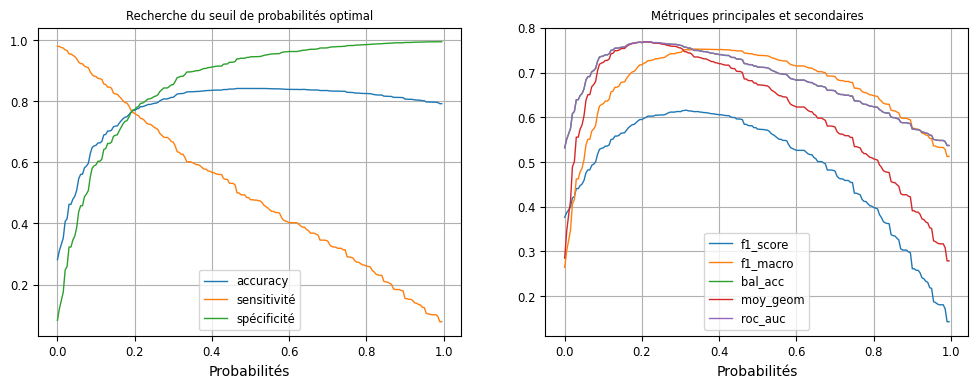

In [135]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_dt0)

In [136]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_dt0['Probabilités'].values
f = df_metrics_probas_dt0['sensitivité'].values
g = df_metrics_probas_dt0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_dt0, y_prob_thres_dt0) = thres_info[0]

In [137]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_dt0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_dt0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_dt0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.19

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25063  7827
1             2124  7223

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.76      0.83     32890
           1       0.48      0.77      0.59      9347

    accuracy                           0.76     42237
   macro avg       0.70      0.77      0.71     42237
weighted avg       0.82      0.76      0.78     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.76      0.77      0.83      0.77      0.59     32890
          1       0.48      0.77      0.76      0.59      0.77      0.59      9347

avg / total       0.82      0.76      0.77      0.78      0.77      0.59     42237



- `0.76 < accuracy, sensibilité, spécificité, moyenne géométrique < 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.59`
- `f1-macro = 0.71`

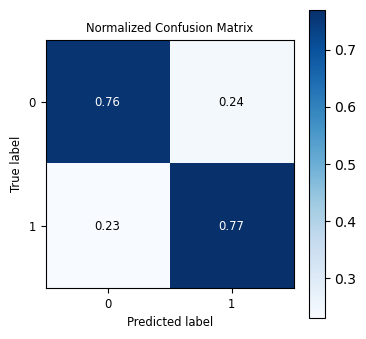

In [138]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

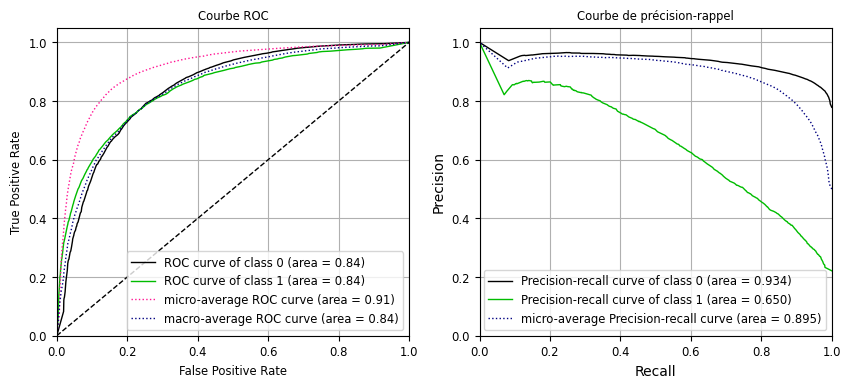

In [139]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

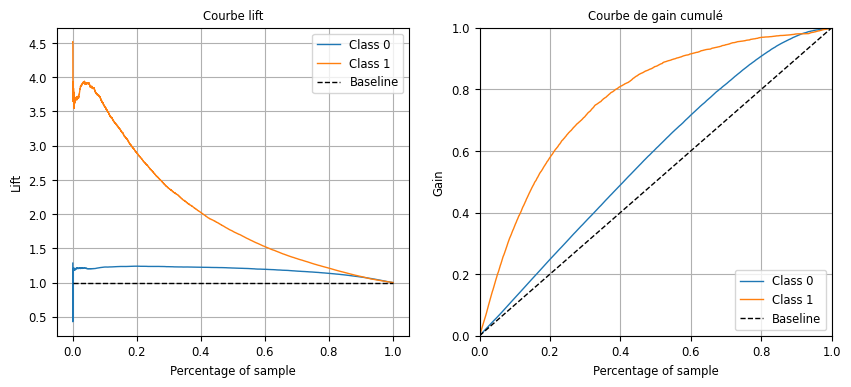

In [140]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weigth = 'balanced'

In [141]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight='balanced')

In [142]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['entropy','gini'], 'max_depth':np.arange(6,12,1)}

In [143]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt1 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt1.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [144]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'criterion': 'gini', 'max_depth': 9}",0.727248,0.764157,0.763111,0.838771,0.544515,0.054859
2,"{'criterion': 'entropy', 'max_depth': 8}",0.726071,0.763521,0.762443,0.843751,0.644354,0.057811
3,"{'criterion': 'entropy', 'max_depth': 7}",0.725214,0.764157,0.763370,0.845176,0.449485,0.049240


In [145]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'criterion': 'gini', 'max_depth': 9} 

Train Data Score: 0.7514296951954123
Test Data Score: 0.731677743396552


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [146]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_dt1_train = error_metrics(gcv_dt1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_dt1_test = error_metrics(gcv_dt1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_dt1_train)
display("TEST", cv_dt1_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.727178,0.764121,0.763079,0.838617,0.261765,0.03629


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.703553,0.751675,0.751293,0.815621,0.097336,0.014906


In [147]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_dt1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.304920,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.720031,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.123098,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.094621,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.452282,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [148]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_dt1 = compute_metrics_with_probas(df_probas_test, y_test)

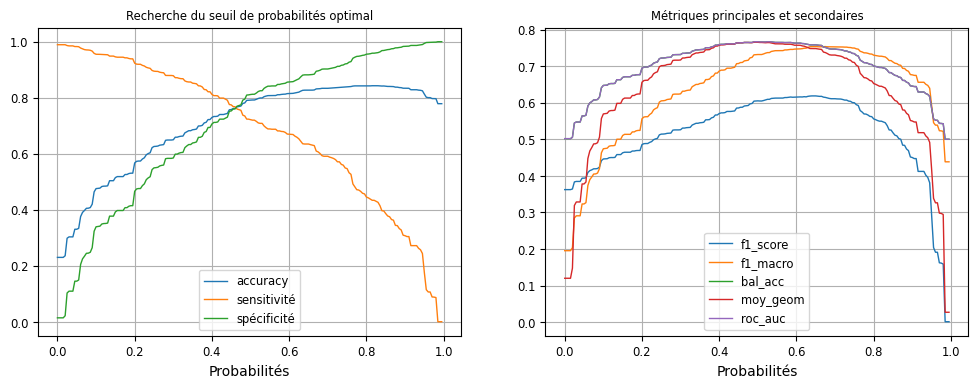

In [149]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_dt1)

In [150]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_dt1['Probabilités'].values
f = df_metrics_probas_dt1['sensitivité'].values
g = df_metrics_probas_dt1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_dt1, y_prob_thres_dt1) = thres_info[0]

In [151]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_dt1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_dt1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_dt1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.46

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24994  7896
1             2173  7174

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.76      0.83     32890
           1       0.48      0.77      0.59      9347

    accuracy                           0.76     42237
   macro avg       0.70      0.76      0.71     42237
weighted avg       0.82      0.76      0.78     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.76      0.77      0.83      0.76      0.58     32890
          1       0.48      0.77      0.76      0.59      0.76      0.58      9347

avg / total       0.82      0.76      0.77      0.78      0.76      0.58     42237



- `0.76 < accuracy, sensibilité, spécificité, moyenne géométrique < 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `f1-score = 0.59`
- `f1-score = 0.71`

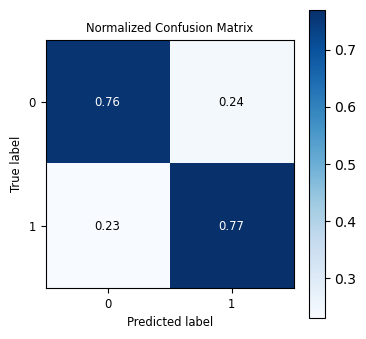

In [152]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

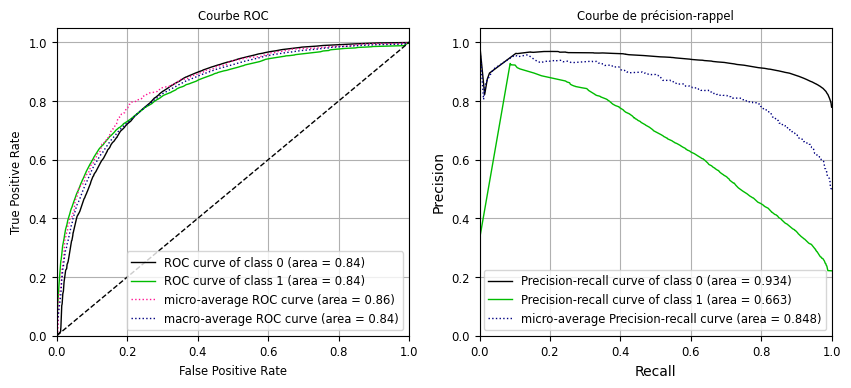

In [153]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

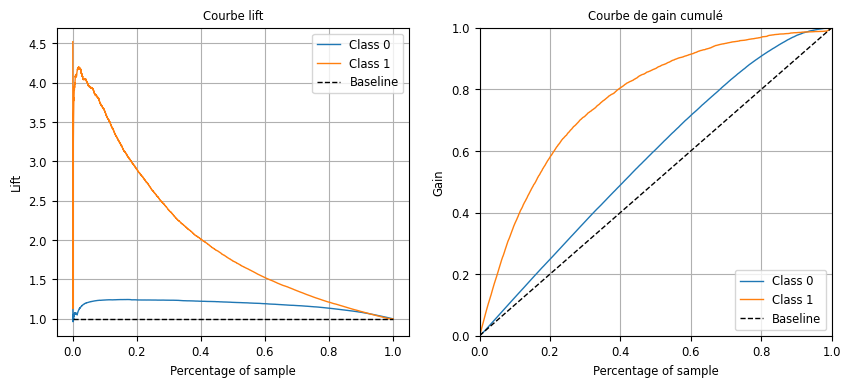

In [154]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [155]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

In [156]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.40,0.60,21)

In [157]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_dt = {'criterion':[gcv_dt0.best_params_['criterion']], 'max_depth':[gcv_dt0.best_params_['max_depth']], 
                 'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [158]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt2 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.4, 1: 0.6},
                                          {0: 0.41000000000000003, 1: 0.59},
                                          {0: 0.42000000000000004, 1: 0.58},
                                          {0: 0.43, 1: 0.5700000000000001},
                                          {0: 0.44, 1: 0.56},
                                          {0: 0.45, 1: 0.55},
                                          {0: 0.46, 1: 0.54},
                                          {0: 0.47000000000000003, 1: 0.53},
                                          {0: 0.48, 1: 0.52},
                                          {0: 0.49, 1: 0.51}, {0: 0.5, 1: 0.5},
                                          {0: 0.51, 1: 0.49},
                                          {0: 0.52, 1: 0....
                                          {0: 0.55, 1: 0.44999999999999996},
                                          {0: 0.56, 1: 0.43999999999999995},
                                          {0: 0.5700000000000001,
                                           1: 0.42999999999999994},
                                          {0: 0.58, 1: 0.42000000000000004},
                                          {0: 0.59, 1: 0.41000000000000003},
                                          {0: 0.6, 1: 0.4}],
                         'criterion': ['entropy'], 'max_depth': [10]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [159]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'entropy', 'max_depth': 10}",0.745769,0.737047,0.717378,0.829181,0.579542,0.052868
2,"{'class_weight': {0: 0.41000000000000003, 1: 0.59}, 'criterion': 'entropy', 'max_depth': 10}",0.745339,0.735173,0.714206,0.830363,0.646525,0.063517
3,"{'class_weight': {0: 0.43, 1: 0.5700000000000001}, 'criterion': 'entropy', 'max_depth': 10}",0.743368,0.730010,0.705961,0.829833,0.671198,0.063223


In [160]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'class_weight': {0: 0.4, 1: 0.6}, 'criterion': 'entropy', 'max_depth': 10} 

Train Data Score: 0.7805149332480675
Test Data Score: 0.7509609774624557


- la méthode **fait l'objet d'un léger sur-apprentissage** (score=f1_macro)

In [161]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_dt2_train = error_metrics(gcv_dt2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_dt2_test = error_metrics(gcv_dt2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_dt2_train)
display("TEST", cv_dt2_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.745864,0.737181,0.717561,0.829465,0.281277,0.032336


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.735333,0.727491,0.706648,0.806107,0.129827,0.01147


In [162]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_dt2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.115124,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.331288,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.038298,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.074954,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.288279,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [163]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_dt2 = compute_metrics_with_probas(df_probas_test, y_test)

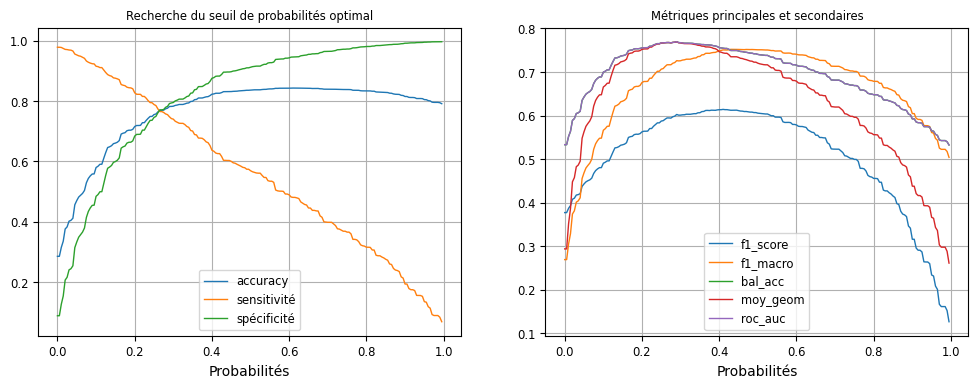

In [164]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_dt2)

In [165]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_dt2['Probabilités'].values
f = df_metrics_probas_dt2['sensitivité'].values
g = df_metrics_probas_dt2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_dt2, y_prob_thres_dt2) = thres_info[0]

In [166]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_dt2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_dt2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_dt2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.26

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25016  7874
1             2114  7233

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.76      0.83     32890
           1       0.48      0.77      0.59      9347

    accuracy                           0.76     42237
   macro avg       0.70      0.77      0.71     42237
weighted avg       0.82      0.76      0.78     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.76      0.77      0.83      0.77      0.59     32890
          1       0.48      0.77      0.76      0.59      0.77      0.59      9347

avg / total       0.82      0.76      0.77      0.78      0.77      0.59     42237



- `0.76 < accuracy, sensibilité, spécificité, moyenne géométrique < 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.59`
- `F1-score = 0.71`

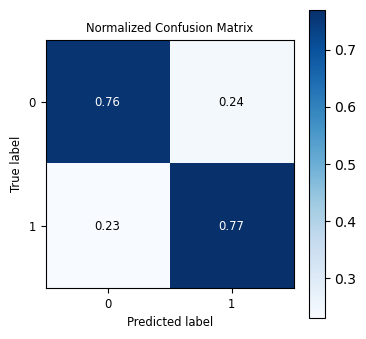

In [167]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

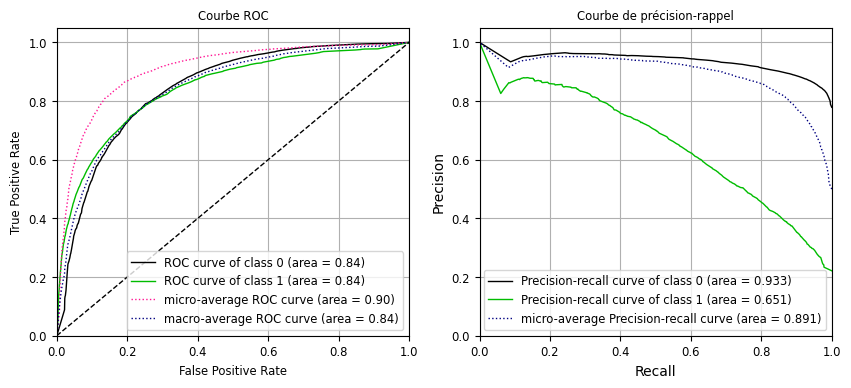

In [168]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

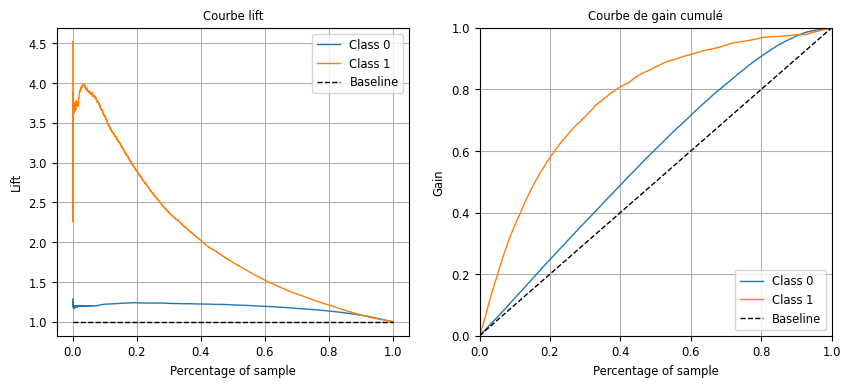

In [169]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [170]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_dt = pd.DataFrame(data=[cv_dt0_train.values[0], cv_dt0_test.values[0], cv_dt1_train.values[0], cv_dt1_test.values[0], 
                           cv_dt2_train.values[0], cv_dt2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'],
                     index=['dt0 : train', 'dt0 : test', 'dt1 : train', 'dt1 : test', 'dt2 : train', 'dt2 : test'])
cv_dt.index.name='Cross validation'
cv_dt.to_csv('../scores/cv_dt_'+param_ru+'.csv')
cv_dt

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
dt0 : train,0.735274,0.713295,0.678028,0.829859,0.262049,0.026377
dt0 : test,0.726289,0.704153,0.665158,0.809196,0.111770,0.014061
dt1 : train,0.727178,0.764121,0.763079,0.838617,0.261765,0.036290
dt1 : test,0.703553,0.751675,0.751293,0.815621,0.097336,0.014906
dt2 : train,0.745864,0.737181,0.717561,0.829465,0.281277,0.032336
dt2 : test,0.735333,0.727491,0.706648,0.806107,0.129827,0.011470


In [171]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_dt = {'dt0' : df_metrics_probas_dt0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_dt0],
           'dt1' : df_metrics_probas_dt1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_dt1],
           'dt2' : df_metrics_probas_dt2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_dt2]}

test_dt = pd.DataFrame(data=[data_dt['dt0'], data_dt['dt1'], data_dt['dt2']], 
                       columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                       index=['dt0', 'dt1', 'dt2'])
test_dt.index.name='Final Test'
test_dt.to_csv('../scores/test_dt_'+param_ru+'.csv')
test_dt

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
dt0,0.592122,0.713242,0.767393,0.767374,0.767393
dt1,0.587623,0.709983,0.763723,0.763714,0.763723
dt2,0.591560,0.712574,0.767214,0.767185,0.767214


## Résumé des performances

In [70]:
# concaténation des résultats de performance
cv_lr_no_resampling = pd.read_csv('../scores/cv_lr_'+param_ru+'.csv', index_col=0)
cv_rf_no_resampling = pd.read_csv('../scores/cv_rf_'+param_ru+'.csv', index_col=0)    
cv_svm_no_resampling = pd.read_csv('../scores/cv_svm_'+param_ru+'.csv', index_col=0)
cv_knn_no_resampling = pd.read_csv('../scores/cv_knn_'+param_ru+'.csv', index_col=0)
cv_dt_no_resampling = pd.read_csv('../scores/cv_dt_'+param_ru+'.csv', index_col=0)

df_cv_no_resampling = pd.concat([cv_lr_no_resampling, cv_rf_no_resampling, cv_svm_no_resampling, 
                                cv_knn_no_resampling, cv_dt_no_resampling], axis=0)

test_lr_no_resampling = pd.read_csv('../scores/test_lr_'+param_ru+'.csv', index_col=0)
test_rf_no_resampling = pd.read_csv('../scores/test_rf_'+param_ru+'.csv', index_col=0)    
test_svm_no_resampling = pd.read_csv('../scores/test_svm_'+param_ru+'.csv', index_col=0)
test_knn_no_resampling = pd.read_csv('../scores/test_knn_'+param_ru+'.csv', index_col=0)
test_dt_no_resampling = pd.read_csv('../scores/test_dt_'+param_ru+'.csv', index_col=0)

df_test_no_resampling = pd.concat([test_lr_no_resampling, test_rf_no_resampling, test_svm_no_resampling, 
                                  test_knn_no_resampling, test_dt_no_resampling], axis=0)

In [71]:
# affichage du résumé des performances
display(df_cv_no_resampling)
display(df_test_no_resampling)

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
lr0 : train,0.736005,0.710580,0.671261,0.855555,0.226933,0.026132
lr0 : test,0.738415,0.713246,0.675124,0.854329,0.076316,0.011583
lr1 : train,0.725953,0.773905,0.773847,0.855871,0.088414,0.031556
lr1 : test,0.724240,0.771678,0.771569,0.854632,0.028550,0.013031
lr2 : train,0.752934,0.749842,0.735324,0.855736,0.226169,0.025393
lr2 : test,0.752062,0.749375,0.734891,0.854500,0.061458,0.010886
rf0 : train,0.752474,0.723552,0.686018,0.871722,10.696120,1.778577
rf0 : test,0.749087,0.719265,0.679189,0.866143,4.266405,0.656884
rf1 : train,0.769295,0.759949,0.743868,0.872745,10.062423,1.762090


,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
lr1,0.599419,0.719850,0.771800,0.771800,0.771800
lr2,0.600025,0.719908,0.772729,0.772724,0.772729
lr3,0.599619,0.719564,0.772462,0.772457,0.772462
rf0,0.622767,0.737215,0.789638,0.789625,0.789638
rf1,0.625248,0.739583,0.790735,0.790734,0.790735
rf2,0.623168,0.737603,0.789812,0.789801,0.789812
svm0,0.582431,0.705989,0.759705,0.759698,0.759705
svm1,0.611018,0.728502,0.780700,0.780696,0.780700
svm2,0.582835,0.704989,0.761302,0.761232,0.761302
